# Data exploration

### Utils

In [3]:
# import utils
import cv2
import os 
import sys
import matplotlib.pyplot as plt 
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Resize, Compose, Normalize, HorizontalFlip, RandomBrightnessContrast
from torch.utils.data import Dataset, DataLoader
import torch
# import functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *


### Paths

In [4]:
images_path = '../data/processed/images'
labels_path = '../data/processed/labels'

## Data correction

In [5]:
# Check if every image has a label
check_images_labels(images_path=images_path, labels_path=labels_path)

# Number of images
n_images = get_num_images(images_path=images_path)
print(f"Number of images: {n_images}")

All images have corresponding labels
Number of images: 1480


## Loading images

In [6]:
def draw_bounding_box(image_path, bounding_boxes):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_height, img_width = image.shape[:2]

    # Define the colors
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }

    for bbox in bounding_boxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert the coordinates to absolute values
        x_center, y_center = int(x_center * img_width), int(y_center * img_height)
        width, height = int(width * img_width), int(height * img_height)

        # Calculate the top-left and bottom-right corner of the bounding box
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Class color
        color = colors[class_id]

        # Draw the bounding box
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Add the class name
        cv2.putText(
            image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

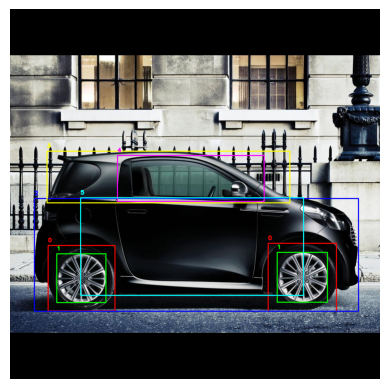

In [7]:
image_path = '../data/processed/images/A_Ast_01.jpg'
image_label_path = '../data/processed/labels/A_Ast_01.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)


# Convert LabelME JSON labels into COCO formats

In [8]:
labelme_dir = "../data/with_labels/json"
coco_labels_file = "../data/with_labels/labels/coco_annotations.json"
labelme_to_coco(labelme_dir, coco_labels_file)

COCO annotations saved to ../data/with_labels/labels/coco_annotations.json


## Visualization COCO Format

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_coco_annotations(coco_json, images_dir, num_samples=5):
    """
    Visualizes COCO annotations by overlaying bounding boxes and segmentation masks on images.
    
    Parameters:
        coco_json (str): Path to the COCO JSON file.
        images_dir (str): Directory containing the images.
        num_samples (int): Number of images to visualize.
    """
    # Load COCO JSON
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    # Map image IDs to image metadata
    image_dict = {img["id"]: img for img in coco_data["images"]}

    # Map annotations by image_id
    annotations_by_image = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Visualize a subset of images
    for img_id, img_data in list(image_dict.items())[:num_samples]:
        img_path = Path(images_dir) / img_data["file_name"]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

        # Overlay annotations
        if img_id in annotations_by_image:
            for ann in annotations_by_image[img_id]:
                # Draw bounding box
                bbox = ann["bbox"]x_min, y_min, width, height = map(int, bbox)
                x_max, y_max = x_min + width, y_min + height
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

                # Draw segmentation (if available)
                if "segmentation" in ann:
                    points = ann["segmentation"][0]
                    points = [(int(points[i]), int(points[i + 1])) for i in range(0, len(points), 2)]
                    for i in range(len(points)):
                        cv2.line(image, points[i], points[(i + 1) % len(points)], color=(255, 0, 0), thickness=2)

        # Display the image with annotations
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Image ID: {img_id}")
        plt.axis("off")
        plt.show()

# Example usage
images_dir = "../data/with_labels/images"        # Path to your image directory
visualize_coco_annotations(coco_labels_file, images_dir, num_samples=2)


SyntaxError: invalid syntax (2899066525.py, line 40)

# Data Preprocessing

## Convert LabelMe labels to mask

In [10]:
images_dir = "../data/with_labels/images"  # Path to normal images
labelme_dir = "../data/with_labels/json"  # Directory containing LabelMe JSON files
output_mask_dir = "../data/with_labels/masks"  # Directory of masks
output_augmentations_dir = "../data/with_labels/augmented"  # Directory to save augmented images

In [11]:

def create_masks(labelme_dir, output_mask_dir):
    """
    Converts LabelMe JSON annotations to binary masks.

    Parameters:
        labelme_dir (str): Directory containing LabelMe JSON files.
        output_mask_dir (str): Directory to save generated masks.
    """
    os.makedirs(output_mask_dir, exist_ok=True)

    for json_file in Path(labelme_dir).glob("*.json"):
        with open(json_file, "r") as f:
            label_data = json.load(f)

        # Get image dimensions
        img_height = label_data["imageHeight"]
        img_width = label_data["imageWidth"]

        # Create an empty mask
        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # Add polygons to the mask
        for shape in label_data["shapes"]:
            if shape["label"] == "window":  # Use only "window" labels
                points = np.array(shape["points"], dtype=np.int32)
                cv2.fillPoly(mask, [points], color=1)

        # Save the mask
        mask_name = Path(label_data["imagePath"]).stem + ".png"
        mask_path = os.path.join(output_mask_dir, mask_name)
        cv2.imwrite(mask_path, mask * 255)  # Convert to 0-255 scale for saving as PNG

    print(f"Masks saved")



In [12]:
create_masks(labelme_dir, output_mask_dir)

Masks saved


## Masks visualization

In [13]:
def visualize_mask(image_path, mask_path):
    """
    Visualizes the original image and its corresponding mask.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the binary mask.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.show()

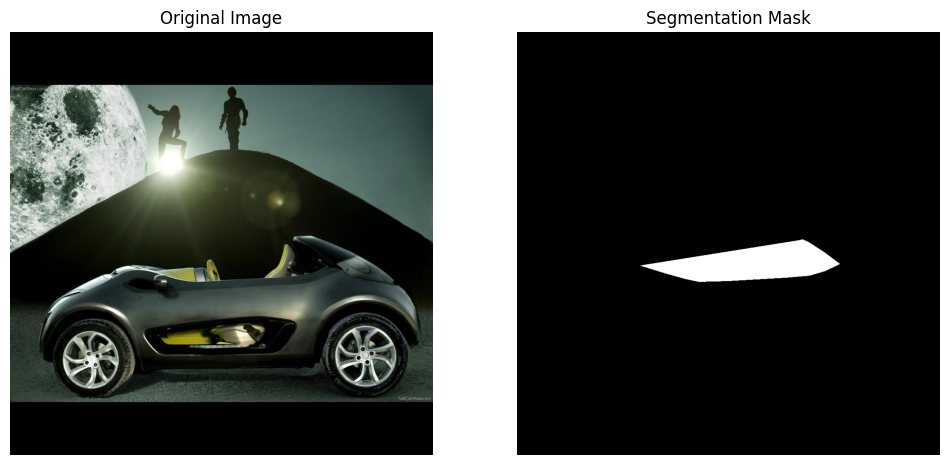

In [14]:
visualize_mask("../data/with_labels/images/A_Cit_01.jpg", "../data/with_labels/masks/A_Cit_01.png")

## Data augmentation

### Define the transformations for segmentation

In [15]:
def augment_dataset(images_dir, masks_dir, output_dir, num_augmented=5):
    """
    Augments an entire dataset of images and corresponding masks for segmentation tasks.

    Parameters:
        images_dir (str): Directory containing input images.
        masks_dir (str): Directory containing input masks.
        output_dir (str): Directory to save augmented images and masks.
        num_augmented (int): Number of augmented copies to generate for each image-mask pair.
    """
    transform = A.Compose(
        [
            A.HorizontalFlip(p=0.5),  # Flips image and mask horizontally.
            A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast of the image.
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.05,
                rotate_limit=15,
                border_mode=0,  # Padding ensures dimensions remain consistent.
                p=0.5,
            ),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Adds slight blurring.
            A.HueSaturationValue(
                hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3
            ),  # Changes hue, saturation, and value.
            A.Resize(1024, 1024, always_apply=True),  # Ensures image and mask are resized consistently.
        ]
    )

    # Create output directories
    output_images_dir = Path(output_dir) / "images"
    output_masks_dir = Path(output_dir) / "masks"
    output_images_dir.mkdir(parents=True, exist_ok=True)
    output_masks_dir.mkdir(parents=True, exist_ok=True)

    # Process all images and masks
    for image_path in Path(images_dir).glob("*.jpg"):
        mask_path = Path(masks_dir) / f"{image_path.stem}.png"
        if not mask_path.exists():
            print(f"Mask for {image_path.name} not found. Skipping.")
            continue

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        for i in range(num_augmented):
            # Apply augmentation
            transformed = transform(image=image, mask=mask)
            aug_image = transformed["image"]
            aug_mask = transformed["mask"]

            # Save augmented image and mask
            aug_image_name = f"{image_path.stem}_aug_{i}.jpg"
            aug_mask_name = f"{mask_path.stem}_aug_{i}.png"
            cv2.imwrite(
                str(output_images_dir / aug_image_name),
                cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR),
            )
            cv2.imwrite(str(output_masks_dir / aug_mask_name), aug_mask)

    print(f"Augmented dataset saved in {output_dir}")

In [16]:
augment_dataset(images_dir, output_mask_dir, output_augmentations_dir, num_augmented=5)

Augmented dataset saved in ../data/with_labels/augmented


### Visualize augmented images and masks

In [17]:
def visualize_augmented_data(image_dir, mask_dir, num_samples=5):
    """
    Visualizes a few augmented image-mask pairs.

    Parameters:
        image_dir (str): Directory containing augmented images.
        mask_dir (str): Directory containing augmented masks.
        num_samples (int): Number of samples to visualize.
    """
    image_paths = sorted(Path(image_dir).glob("*.jpg"))[:num_samples]
    mask_paths = sorted(Path(mask_dir).glob("*.png"))[:num_samples]

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Augmented Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Augmented Mask: {mask_path.name}")
        plt.axis("off")

        plt.show()

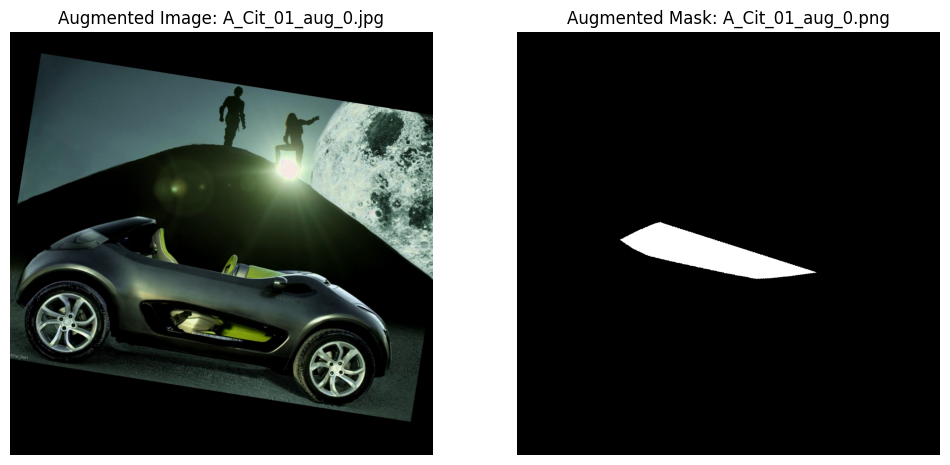

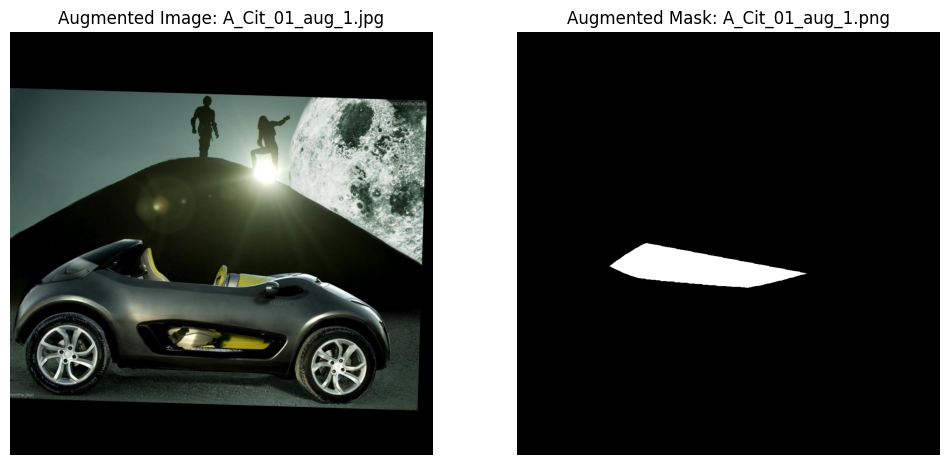

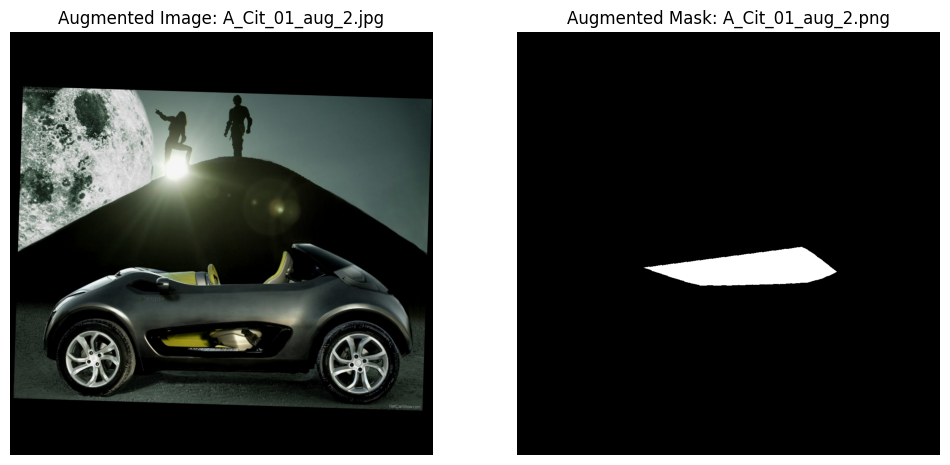

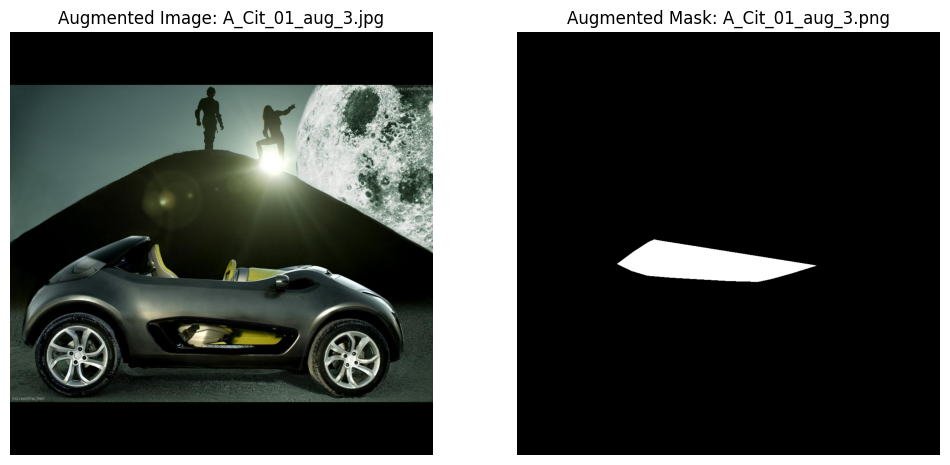

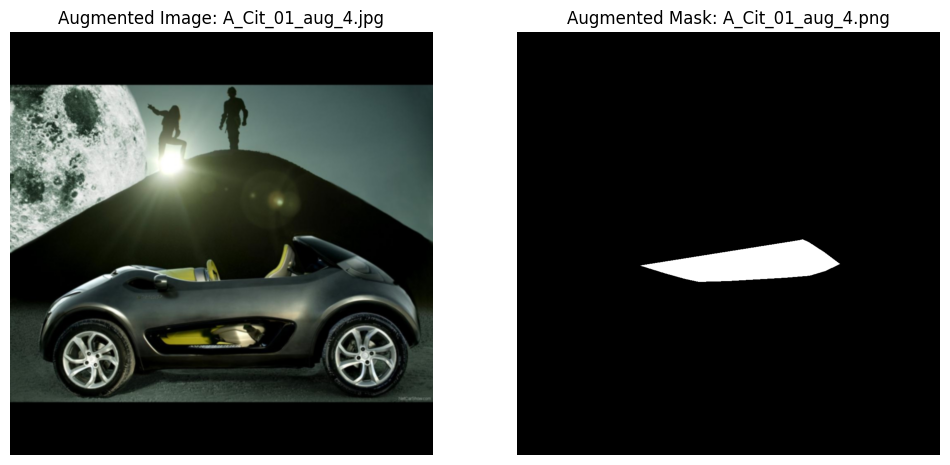

In [18]:
augmented_images_dir = "../data/with_labels/augmented/images"
augmented_masks_dir = "../data/with_labels/augmented/masks"
visualize_augmented_data(augmented_images_dir, augmented_masks_dir)

# Split of dateset

In [6]:
# Example usage
augmented_images_dir = "../data/with_labels/augmented/images"
augmented_masks_dir = "../data/with_labels/augmented/masks"
output_split_dir = "../data/split"

In [7]:
split_augmented_dataset(augmented_images_dir, augmented_masks_dir, output_split_dir)

Dataset split into train, val, and test sets in ../data/split


In [10]:
def visualize_split(split_dir, num_samples=1):
    images_dir = Path(split_dir) / "images"
    masks_dir = Path(split_dir) / "masks"

    image_paths = sorted(images_dir.glob("*.jpg"))[:num_samples]
    mask_paths = sorted(masks_dir.glob("*.png"))[:num_samples]

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask: {mask_path.name}")
        plt.axis("off")

        plt.show()

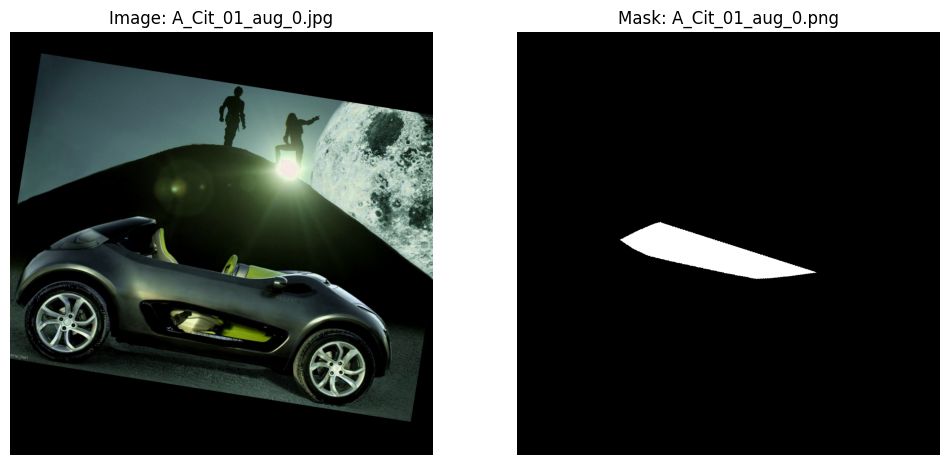

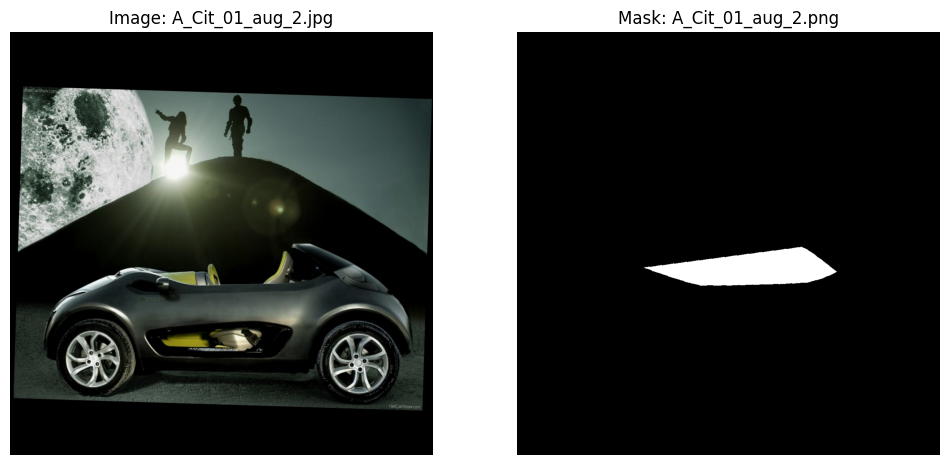

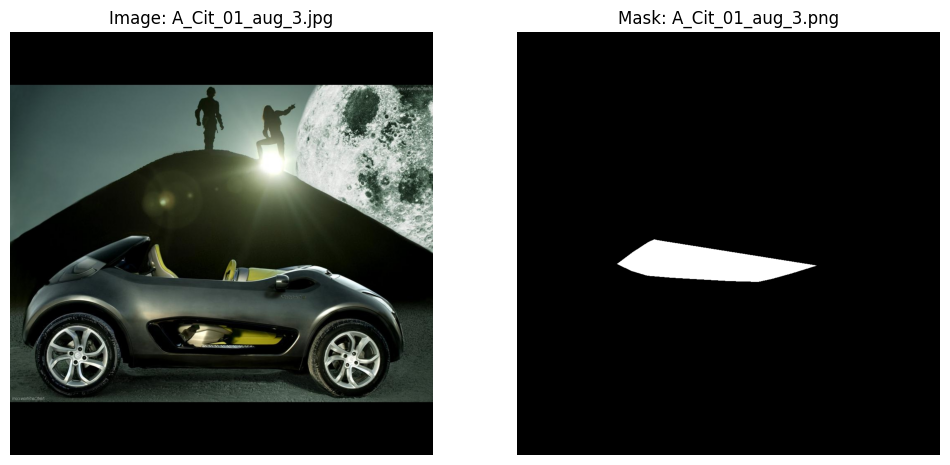

In [11]:
visualize_split("../data/split/train")
visualize_split("../data/split/val")
visualize_split("../data/split/test")

# Dataset class

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_paths = sorted(list(Path(images_dir).glob("*.jpg")))
        self.mask_paths = sorted(list(Path(masks_dir).glob("*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Normalize mask (binary: 0 or 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

# Data augmentations during training

In [6]:
# Training augmentations
train_transform = Compose(
    [
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.2),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),  # Resize to 512x512 (adjust based on model input size)
        ToTensorV2(),
    ]
)

# Validation augmentations
val_transform = Compose(
    [
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),
        ToTensorV2(),
    ]
)

# Data loader

In [7]:
train_images_dir = "../data/split/train/images"
train_masks_dir = "../data/split/train/masks"
val_images_dir = "../data/split/val/images"
val_masks_dir = "../data/split/val/masks"

train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=train_transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model definition

In [ ]:
%pip install segmentation_models_pytorch

In [7]:
from segmentation_models_pytorch import Unet

# Define the U-Net model
model = Unet(
    encoder_name="resnet34",  # Encoder backbone
    encoder_weights="imagenet",  # Pretrained on ImageNet
    in_channels=3,  # Input channels (RGB)
    classes=1,  # Output channels (binary segmentation)
)

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Loss and optimizer
criterion = BCEWithLogitsLoss()  # Combines sigmoid activation and binary cross-entropy
optimizer = Adam(model.parameters(), lr=0.001)


def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch} to {path}")


best_val_loss = float("inf")
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

    # Save periodic checkpoints
    if epoch % 5 == 0:
        save_checkpoint(model, optimizer, epoch, path=f"checkpoint_epoch_{epoch}.pth")

In [ ]:
def visualize_predictions(model, image, mask):
    model.eval()
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred).squeeze().cpu().numpy() > 0.5

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()


# Visualize on a validation sample
sample_image, sample_mask = next(iter(val_loader))
visualize_predictions(model, sample_image[7], sample_mask[7])

In [ ]:
def compute_metrics(model, dataloader):
    model.eval()
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Compute IoU and Dice for each sample
            for pred, mask in zip(preds, masks):
                intersection = (pred * mask).sum()
                union = pred.sum() + mask.sum() - intersection
                iou = intersection / (union + 1e-6)
                dice = 2 * intersection / (pred.sum() + mask.sum() + 1e-6)

                iou_scores.append(iou.item())
                dice_scores.append(dice.item())

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    print(f"Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")


# Evaluate on the test set
test_images_dir = "/kaggle/input/cars-side/split/test/images"
test_masks_dir = "/kaggle/input/cars-side/split/test/masks"
test_dataset = SegmentationDataset(
    test_images_dir, test_masks_dir, transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

compute_metrics(model, test_loader)

In [12]:
import random

def visualize_test_results(model, dataloader, num_samples=10):
    """
    Visualizes random test results by displaying original images, true masks, and predicted masks.

    Parameters:
        model (torch.nn.Module): Trained model for inference.
        dataloader (DataLoader): DataLoader containing test dataset.
        num_samples (int): Number of random samples to visualize.
    """
    model.eval()

    # Flatten the dataset into a list of indices
    dataset_indices = list(range(len(dataloader.dataset)))

    # Randomly sample indices
    selected_indices = random.sample(dataset_indices, min(num_samples, len(dataset_indices)))

    with torch.no_grad():
        for idx in selected_indices:
            # Retrieve the image and mask at the selected index
            image, mask = dataloader.dataset[idx]

            # Convert to device and add batch dimension
            image_tensor = image.unsqueeze(0).to(device)
            mask_tensor = mask.unsqueeze(0).to(device)

            # Model prediction
            output = model(image_tensor)
            pred = (torch.sigmoid(output) > 0.5).float()

            # Visualize
            plt.figure(figsize=(12, 6))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(image.permute(1, 2, 0).cpu().numpy())
            plt.title("Original Image")
            plt.axis("off")

            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask.squeeze().cpu().numpy(), cmap="gray")
            plt.title("True Mask")
            plt.axis("off")

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred.squeeze().cpu().numpy(), cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()


## Load checkpoint

/var/folders/w7/n9y0bc4n5zgb8gg118j_j66h0000gn/T/ipykernel_43104/2373088003.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoi

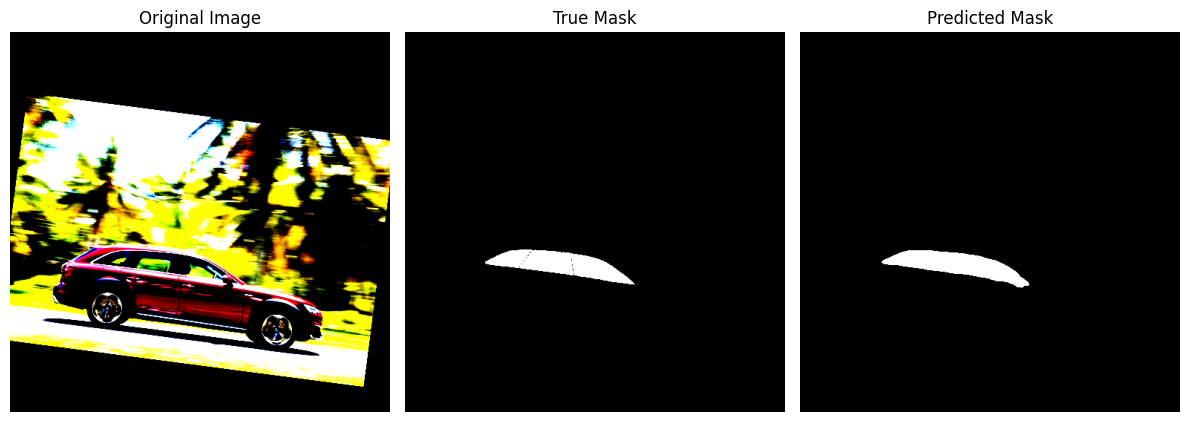

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].


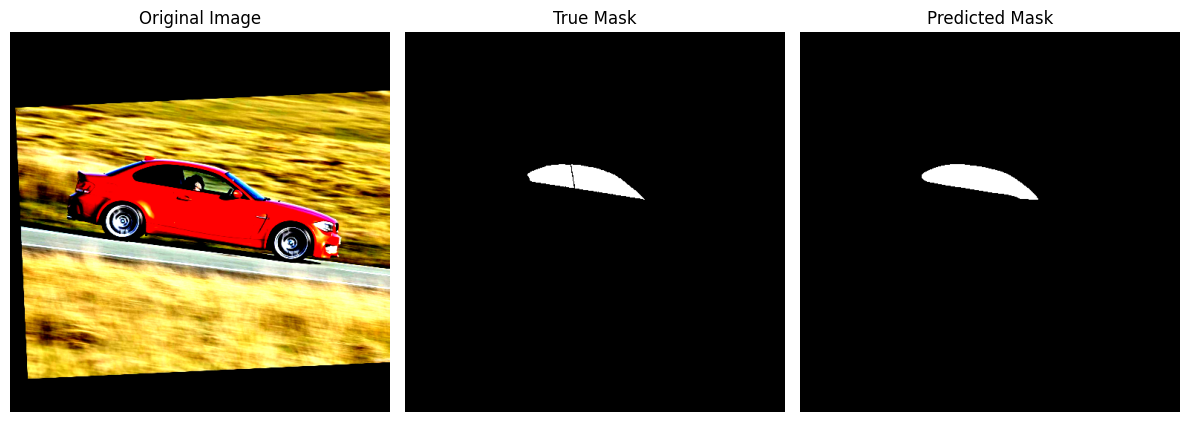

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


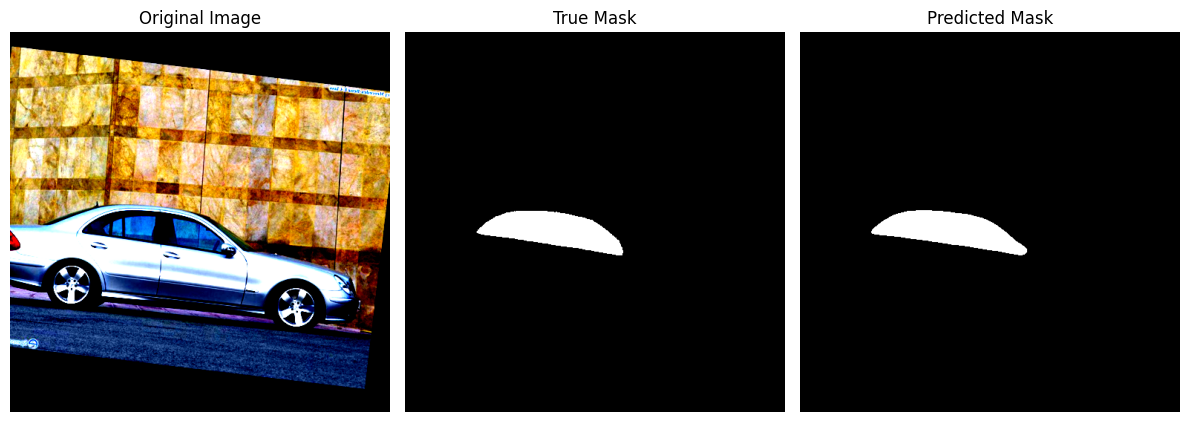

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


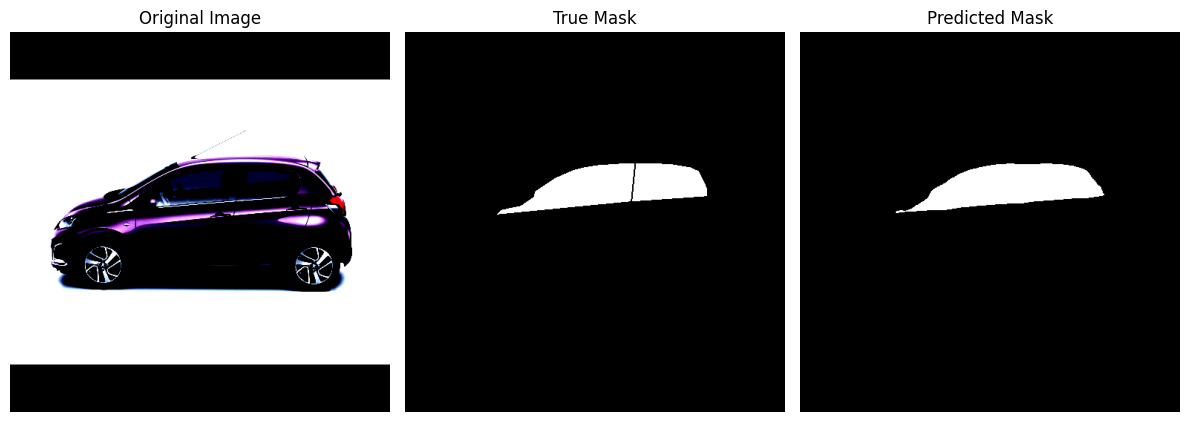

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


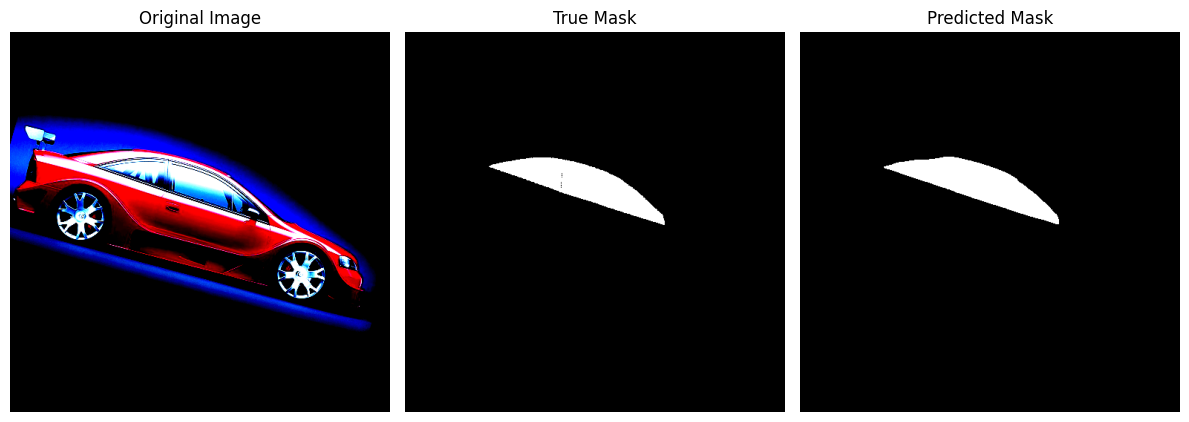

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4439216].


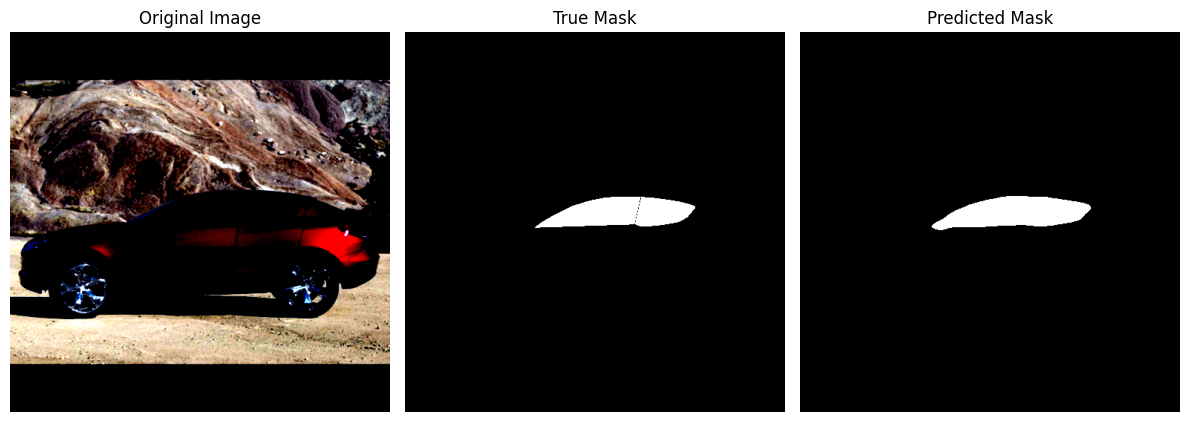

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225705].


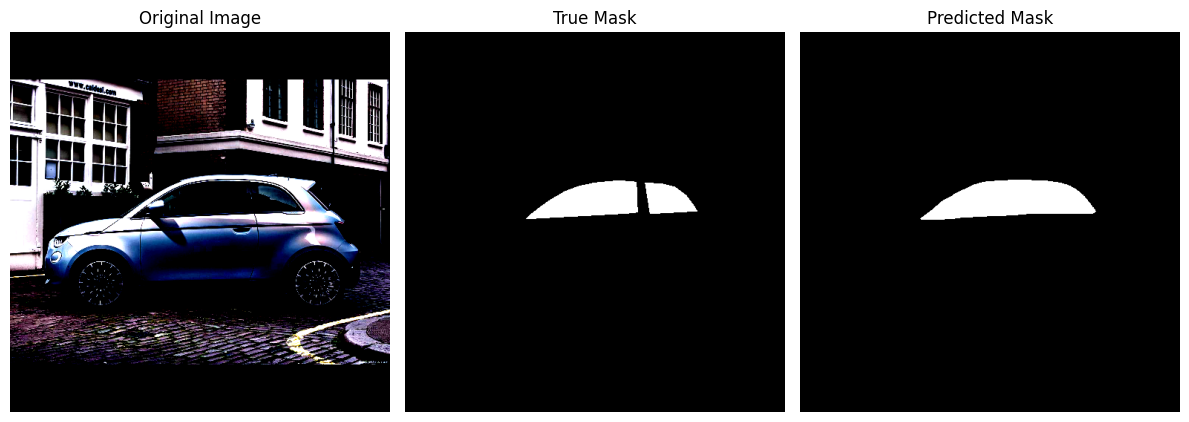

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5572114].


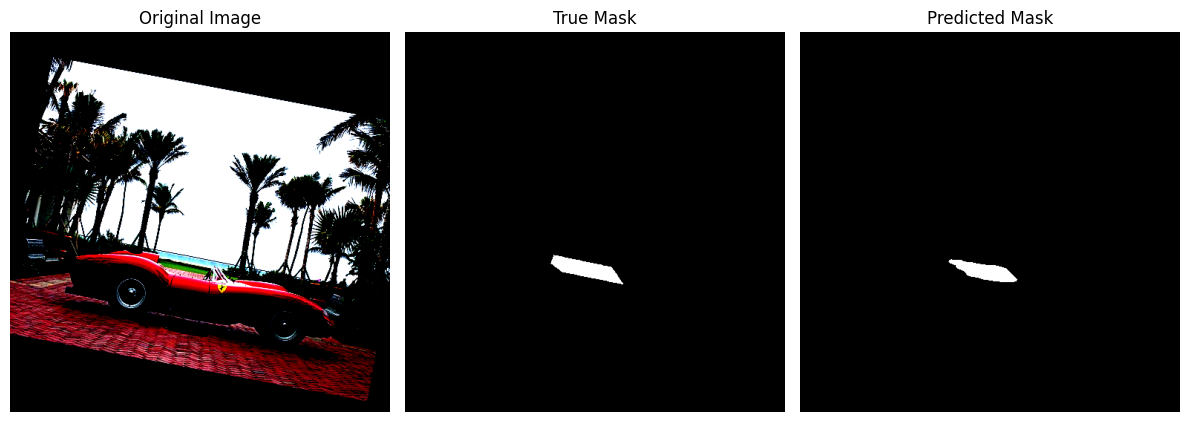

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6269279].


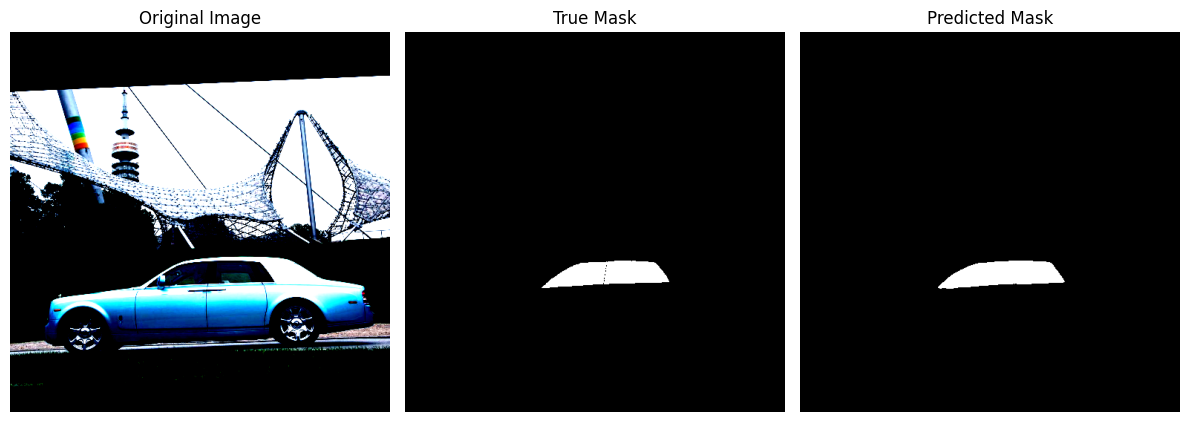

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5484967].


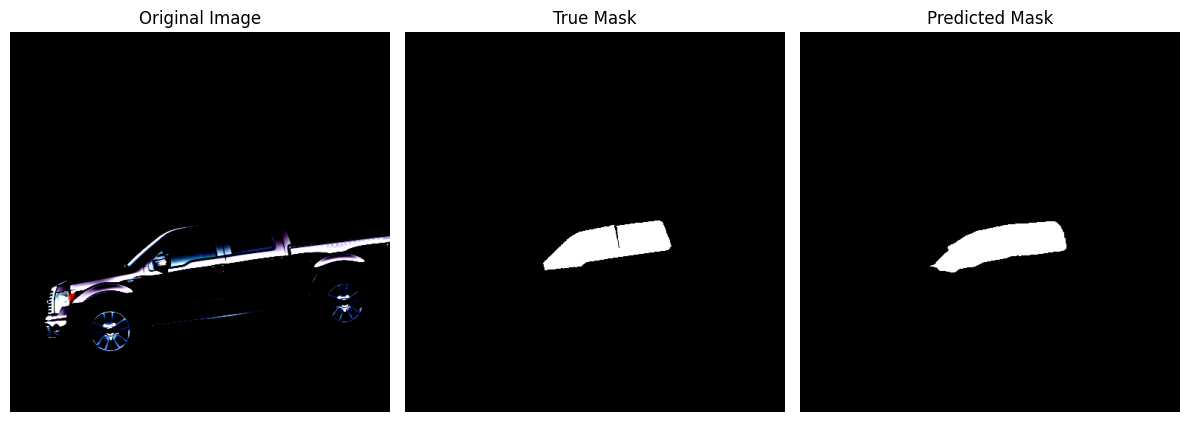

In [14]:
from segmentation_models_pytorch import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(encoder_name="resnet34", in_channels=3, classes=1).to(device)
model.load_state_dict(torch.load("../checkpoints/best_model.pth", map_location=device))
model.eval()

test_images_dir = "../data/split/test/images"
test_masks_dir = "../data/split/test/masks"

test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    Resize(512, 512),
    ToTensorV2(),
])

test_dataset = SegmentationDataset(test_images_dir, test_masks_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 3. Visualize predictions
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()
    
    visualize_test_results(model, test_loader, num_samples=10)
    break 